In [151]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from tqdm import tqdm

In [152]:
def set_seed():
    np.random.seed(20030427)

In [153]:
def simulate_sabr(T, n_steps, F0, alpha_sabr0, beta, rho, nu):
    """
    Simulates a SABR model path using Euler discretization.

    Parameters:
    - T: Total time horizon.
    - n_steps: Number of time steps.
    - F0: Initial forward price.
    - alpha_sabr0: Initial SABR volatility.
    - beta: Elasticity parameter (0 <= beta <= 1).
    - rho: Correlation between price and volatility.
    - nu: Volatility of volatility.

    Returns:
    - t: Time grid.
    - F: Simulated price path.
    - alpha_sabr: Simulated volatility path.
    """
    dt = T / n_steps
    t = np.linspace(0, T, n_steps)
    F = np.zeros(n_steps)
    alpha_sabr = np.zeros(n_steps)
    F[0] = F0
    alpha_sabr[0] = alpha_sabr0
    
    # Generate correlated Brownian motions
    dW1 = np.random.normal(0, np.sqrt(dt), n_steps)
    dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt), n_steps)
    
    for i in range(1, n_steps):
        # Prevent division by zero when beta < 1
        if F[i-1] < 1e-8:
            F[i-1] = 1e-8
            
        # Update volatility
        alpha_sabr[i] = alpha_sabr[i-1] + nu * alpha_sabr[i-1] * dW2[i-1]
        alpha_sabr[i] = max(alpha_sabr[i], 1e-6)  # Avoid negative volatility
        
        # Update forward price
        dF = alpha_sabr[i-1] * (F[i-1] ** beta) * dW1[i-1]
        F[i] = F[i-1] + dF
        
    return t, F, alpha_sabr

In [154]:
from scipy.stats import norm

def sabr_implied_vol(S,K, T, vol, beta, rho,volvol):
    r = 0
    q = 0

    F = S * np.exp((r - q) * T)
    x = (F * K) ** ((1 - beta) / 2)
    y = (1 - beta) * np.log(F / K)
    A = vol / (x * (1 + y * y / 24 + y * y * y * y / 1920))
    B = 1 + T * (
        ((1 - beta) ** 2) * (vol * vol) / (24 * x * x)
        + rho * beta * volvol * vol / (4 * x)
        + volvol * volvol * (2 - 3 * rho * rho) / 24
    )
    Phi = (volvol * x / vol) * np.log(F / K)
    Chi = np.log((np.sqrt(1 - 2 * rho * Phi + Phi * Phi) + Phi - rho) / (1 - rho))

    SABRIV = np.where(F == K, vol * B / (F ** (1 - beta)), A * B * Phi / Chi)

    return SABRIV 

def bs_call(iv, T, S, K):
    r = 0
    q = 0
    d1 = (np.log(S / K) + (r - q + iv * iv / 2) * T) / (iv * np.sqrt(T))
    d2 = d1 - iv * np.sqrt(T)
    bs_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return bs_price


def bs_delta(sigma, T, S, K, r):
    r=0
    q=0
    iv = sigma
    d1 = (np.log(S / K) + (r - q + iv * iv / 2) * T) / (iv * np.sqrt(T))
    bs_delta = np.exp(-q * T) * norm.cdf(d1)
    return bs_delta

In [155]:
def sabr_delta(sigma, T, S, K, beta, volvol, rho):
    r= 0
    q= 0
    sabr_iv = sabr_implied_vol(S, K, T,sigma, beta, rho, volvol)
    ds = 1e-6 * S
    #dsigma = 1e-6 * sigma
    dsigma_ds = (sabr_implied_vol(S+ds, K, T,sigma, beta, rho, volvol)- sabr_implied_vol(S-ds, K, T,sigma, beta, rho, volvol)) / ds / 2
    #dsigma_dsigma0 = (sabr_implied_vol(sigma+dsigma, T, S, K, r, q, beta, volvol, rho) - sabr_implied_vol(sigma-dsigma, T, S, K, r, q, beta, volvol, rho)) / dsigma / 2
    d = (np.log(S/K)+0.5*sabr_iv**2*T) / (sabr_iv * np.sqrt(T))
    return norm.cdf(d) + np.sqrt(T) * norm.pdf(d) * (dsigma_ds)


def sabr_barlette_delta(sigma, T, S, K, beta, volvol, rho):
    r = 0
    q = 0
    sabr_iv = sabr_implied_vol(S, K, T,sigma, beta, rho, volvol)
    ds = 1e-6 * S
    dsigma = 1e-6 * sigma
    dsigma_ds = (sabr_implied_vol(S+ds, K, T,sigma, beta, rho, volvol) - sabr_implied_vol(S-ds, K, T,sigma, beta, rho, volvol)) / ds / 2
    dsigma_dsigma0 = (sabr_implied_vol(S, K, T,sigma+dsigma, beta, rho, volvol) - sabr_implied_vol(S, K, T,sigma-dsigma, beta, rho, volvol)) / dsigma / 2
    d = (np.log(S/K)+0.5*sabr_iv**2*T) / (sabr_iv * np.sqrt(T))
    return norm.cdf(d) + np.sqrt(T) * norm.pdf(d) * (dsigma_ds+dsigma_dsigma0*rho*volvol/(S**beta))

In [156]:
def sabr_call_price(F, K, T, r, alpha_sabr, beta, rho, nu):
    """
    Computes the European call option price under the SABR model.

    Parameters:
    - F: Forward price.
    - K: Strike price.
    - T: Time to maturity.
    - r: Risk-free rate.
    - alpha_sabr, beta, rho, nu: SABR model parameters.

    Returns:
    - price: Call option price.
    - delta: Delta of the call option.
    """
    vol = sabr_implied_vol(F, K, T, alpha_sabr, beta, rho, nu)
    #print(vol)
    d1 = (np.log(F / K) + 0.5 * vol**2 * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    price = np.exp(-r * T) * (F * norm.cdf(d1) - K * norm.cdf(d2))
    #delta = np.exp(-r * T) * norm.cdf(d1)  # Forward Delta
    return price

In [157]:
def simulate_observed_price(X, alpha, eta, L=1):
    
    P = np.zeros_like(X)
    P[0] = np.round(X[0] / alpha) * alpha
    change_indices = [0]

    for i in range(1, len(X)):
        # 使用第一版的阈值计算方式
        upper_threshold = P[i-1] + alpha * (L - 0.5 + eta)
        lower_threshold = P[i-1] - alpha * (L - 0.5 + eta)
        
        # 直接比较有效价格与阈值
        if X[i] >= upper_threshold:
            P[i] = P[i-1] + L * alpha
            change_indices.append(i)
        elif X[i] <= lower_threshold:
            P[i] = P[i-1] - L * alpha
            change_indices.append(i)
        else:
            P[i] = P[i-1]
    
    return  X, P, change_indices

In [158]:
def plot_uncertainty_zone_matplotlib(X,alpha, eta):
    set_seed()
    X, P, change_indices = simulate_observed_price(X,alpha,eta)
    fig, ax = plt.subplots(figsize=(24, 12))

    # Plot Efficient Price and Observed Price
    ax.plot(t, X, label="Efficient Price", color="blue", linewidth=1.5)
    ax.step(t, P, where="post", label="Observed Price", color="red", linestyle="--", linewidth=1.5)

    # Compute mid prices and uncertainty zone boundaries
    mid_prices = np.zeros_like(X)
    lower_bounds = np.zeros_like(X)
    upper_bounds = np.zeros_like(X)
    shaded_lower = np.full_like(X, np.nan)
    shaded_upper = np.full_like(X, np.nan)

    for i in range(len(X)):
        k = np.round(X[i] / alpha)  # Closest tick level
        mid_prices[i] = (k - 0.5) * alpha  # Mid price between two adjacent ticks
        lower_bounds[i] = mid_prices[i] - alpha * (eta)
        upper_bounds[i] = mid_prices[i] + alpha * (eta)

    # Add grid lines at mid prices, lower, and upper bounds
    all_mid_prices = np.unique(mid_prices)
    all_lower_bounds = np.unique(lower_bounds)
    all_upper_bounds = np.unique(upper_bounds)

    # Horizontal grid lines
    for level in all_mid_prices:
        ax.axhline(y=level, color="green", linestyle="-", linewidth=0.5, alpha=1)
    for level in all_lower_bounds:
        ax.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=1)
    for level in all_upper_bounds:
        ax.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=1)

    # Add shaded area for uncertainty zones
    for i in range(len(change_indices) - 1):
        start = change_indices[i]
        end = change_indices[i + 1]
        #mid_price_at_start = mid_prices[start]
        #lower_at_start = mid_price_at_start - alpha * (eta)
        #upper_at_start = mid_price_at_start + alpha * (eta)

        #shaded_lower[start:end] = lower_at_start
        #shaded_upper[start:end] = upper_at_start + alpha

    # Fill shaded area **evenly**
    #ax.fill_between(t, shaded_lower, shaded_upper, color="gray", alpha=0.2)
        mid_price = mid_prices[start]
        lower = mid_price - alpha * eta
        upper = mid_price + alpha * eta+alpha

        # 填充矩形区域（只填充当前 step）
        ax.fill_between(t[start:end+1], lower, upper, color="gray", alpha=0.2, step="post",edgecolor="none")


    # Labels and title
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Price", fontsize=14)
    ax.set_title("Efficient vs Observed Price with Mid Price and Uncertainty Zone Grid", fontsize=16)
    ax.legend(fontsize=12)
    plt.savefig("UncertaintyZone.pdf",format = "pdf")

    # Show plot
    plt.show()

In [159]:
SABR_PARAMS = {
    'F0': 100,        # 初始价格
    'alpha_sabr0': 0.01,  # 初始波动率 (原alpha0)
    'beta': 1,        # 弹性常数
    'rho': 0.2,         # 价格与波动率的相关系数
    'nu': 0.05,          # 波动率的波动率
}

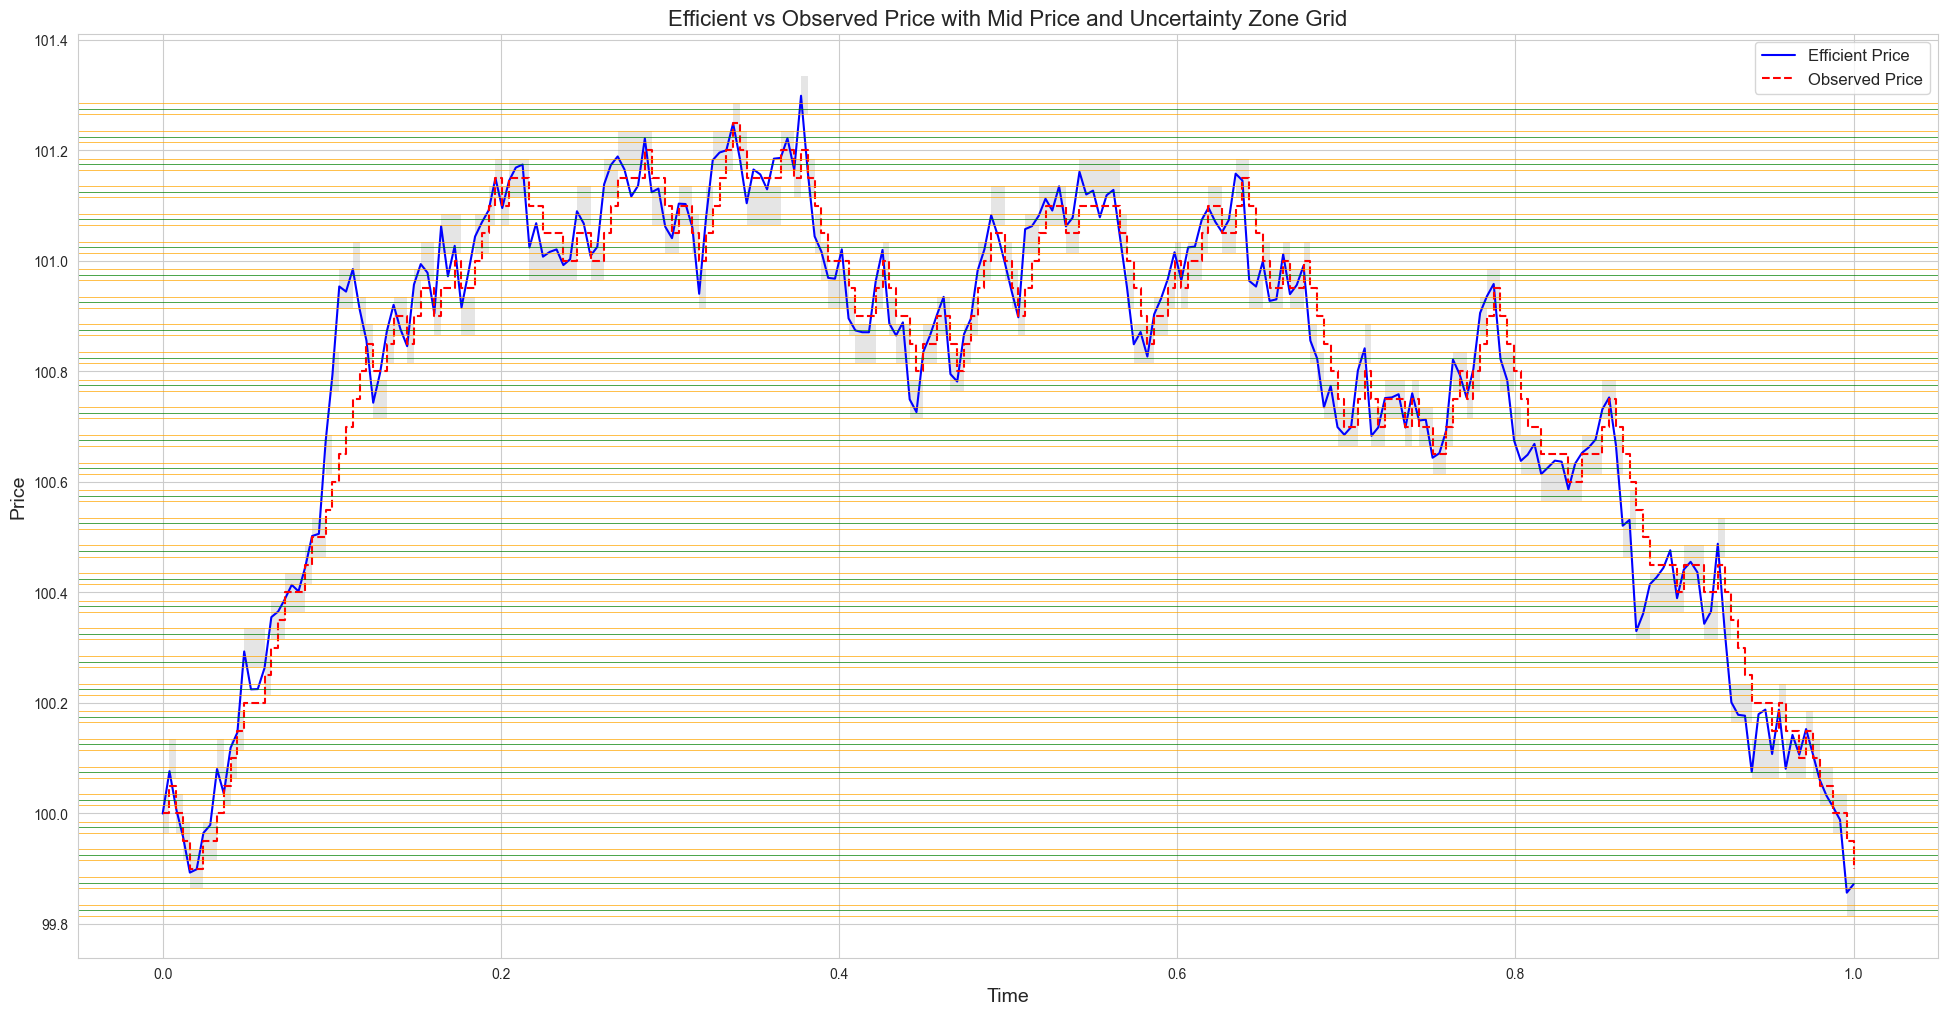

In [160]:
alpha = 0.05      # Tick size
eta = 0.2       # Uncertainty zone width
T = 1.0          # Time horizon
alpha_sabr0 = 0.01  # Volatility, sigma=0.01  5/np.sqrt(252)
F0 = 100      # Initial price
n_steps = 250   # Number of time steps
K = 100 # Strike
number_of_paths = 100 # For Monto Carlo
beta = 1
rho = 0.2
nu = 0.05
t, F, alpha1 = simulate_sabr(T, n_steps, F0, alpha_sabr0,beta,rho,nu)
plot_uncertainty_zone_matplotlib(F,alpha,eta)

In [161]:
eta = 0.05  # Uncertainty zone width
n_steps = 500

In [162]:
def get_optimal_tau(X, alpha, eta):
    tau = [0]
    l = int(round(alpha**(-0.5)))  # 取最近的整数
    current_zone = (X[0] // alpha) * alpha
    threshold = alpha * (l - 0.5 + eta)
    
    for i in range(1, len(X)):
        upper = current_zone + threshold
        lower = current_zone - threshold
        if X[i] > upper or X[i] < lower:
            tau.append(i)
            current_zone = (X[i] // alpha) * alpha
    return tau

In [163]:
def calculate_hedging_error(t, X, alpha_sabr_path, P, tau, K, params, use_efficient_price=True):
    T_total = t[-1]
    portfolio = np.zeros(len(tau))
    positions = np.zeros(len(tau))
    calls = np.zeros(len(tau))
    
    # 初始头寸
    
    
    calls[0]= sabr_call_price(
        X[tau[0]], K, T_total - t[tau[0]], 0,
        params['alpha_sabr0'], params['beta'],
        params['rho'], params['nu']
    )
    positions[0] = sabr_delta(
        params['alpha_sabr0'],T_total - t[tau[0]],
        X[tau[0]],K,params['beta'],
        params['nu'],params['rho']
        )
    portfolio[0] = calls[0] 
    
    for j in range(1, len(tau)):
        # 获取当前波动率参数
        alpha_sabr = alpha_sabr_path[tau[j]]
        
        # 计算价格变化（包含波动率变化影响）
        if use_efficient_price:
            dF = X[tau[j]] - X[tau[j-1]]
            dalpha = alpha_sabr - alpha_sabr_path[tau[j-1]]
        else:
            dF = P[tau[j]] - P[tau[j-1]]
            dalpha = 0  # 观测价格不反映真实波动率变化
            
        # Bartlett对冲需要同时考虑价格和波动率变化
        portfolio[j] = portfolio[j-1] + positions[j-1] * (dF + 0.5*dalpha)  # 简化假设
        
        # 更新头寸
        remaining_T = T_total - t[tau[j]]
        #print(X[tau[j]],K, T_total - t[tau[0]], 0,alpha_sabr, params['beta'],params['rho'], params['nu'])
        calls[j] = sabr_call_price(X[tau[j]], K, remaining_T, 0,alpha_sabr, params['beta'],params['rho'], params['nu'])
        positions[j] = sabr_delta(
        alpha_sabr,T_total - t[tau[j]],
        X[tau[j]],K,params['beta'],
        params['nu'],params['rho']
        )
    #print(calls)
    plt.plot(t[tau], portfolio, label = 'Portfolio value at stopping time')
    plt.plot(t[tau], calls, label = 'Call option price at stopping time')
    
    return calls[-1] - portfolio[-1]

In [164]:
def generate_observed_prices(X, tau, alpha):
    """基于退出时间生成观测价格"""
    P = np.zeros_like(X)
    current_p = None
    for i in range(len(X)):
        if i in tau:
            current_p = np.round(X[i] / alpha) * alpha
        P[i] = current_p if current_p is not None else X[0]
    return P

In [165]:
sabr_call_price(100.1 ,100 ,1.0 ,0 ,0.01 ,1 ,0.2 ,0.05)

np.float64(0.45102286141631254)

In [166]:
sabr_implied_vol(100,100,1,0.01,1,0.05,0.2)

/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_45911/2403508397.py:19: RuntimeWarning: invalid value encountered in scalar divide
  SABRIV = np.where(F == K, vol * B / (F ** (1 - beta)), A * B * Phi / Chi)


array(0.01003346)

In [167]:
bs_call(0.01003346,1,100,100)

np.float64(0.40027546227683786)

In [168]:
sabr_delta(0.01,1,100,100,1,0.005,0.2)-sabr_barlette_delta(0.01,1,100,100,1,0.005,0.2)

/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_45911/2403508397.py:19: RuntimeWarning: invalid value encountered in scalar divide
  SABRIV = np.where(F == K, vol * B / (F ** (1 - beta)), A * B * Phi / Chi)


np.float64(-3.989400695347811e-06)

In [169]:
bs_call(0.04837420293443696,1,100,100)

np.float64(1.9296633340109963)

/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_45911/2403508397.py:19: RuntimeWarning: invalid value encountered in scalar divide
  SABRIV = np.where(F == K, vol * B / (F ** (1 - beta)), A * B * Phi / Chi)
/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_45911/2501987269.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(F / K) + 0.5 * vol**2 * T) / (vol * np.sqrt(T))
/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_45911/2884515782.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  d = (np.log(S/K)+0.5*sabr_iv**2*T) / (sabr_iv * np.sqrt(T))


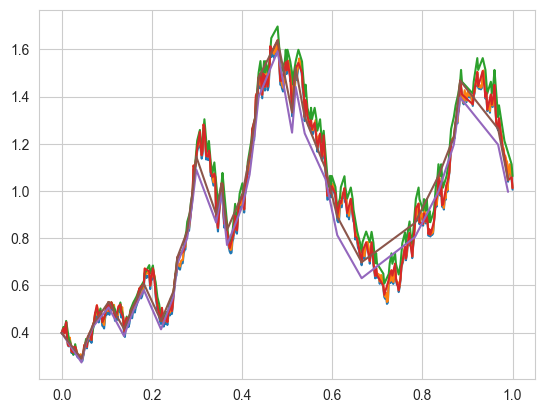

In [170]:
error = [0,0,0]
for i in range(1):
    # Simulate SABR price path
    t, X, alpha_sabr_t = simulate_sabr(T, n_steps, F0, alpha_sabr0, beta, rho, nu)
    #print(get_optimal_tau(X, alpha, eta))
    # Simulate observed price process
    _, P_fixed, tau_fixed = simulate_observed_price(X, alpha, eta)
    tau_optimal = get_optimal_tau(X, alpha, eta)
    P_optimal = generate_observed_prices(X, tau_optimal, alpha)
    #print(tau_optimal)
    # Compute hedging errors for different strategies
    error[1] = calculate_hedging_error(t, X, alpha_sabr_t, X, np.arange(len(t)),K, SABR_PARAMS, True)
    error[2] = calculate_hedging_error(t, X, alpha_sabr_t, P_fixed, tau_fixed, K, SABR_PARAMS, False)
    error[0] = calculate_hedging_error(t, X, alpha_sabr_t, P_optimal, tau_optimal, K, SABR_PARAMS, False)

In [171]:
error_1 = np.zeros(number_of_paths)  
error_2 = np.zeros(number_of_paths) 
error_3 = np.zeros(number_of_paths)

Processing Paths:   0%|          | 0/100 [00:00<?, ?it/s]/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_45911/2403508397.py:19: RuntimeWarning: invalid value encountered in scalar divide
  SABRIV = np.where(F == K, vol * B / (F ** (1 - beta)), A * B * Phi / Chi)
/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_45911/2501987269.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(F / K) + 0.5 * vol**2 * T) / (vol * np.sqrt(T))
/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_45911/2884515782.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  d = (np.log(S/K)+0.5*sabr_iv**2*T) / (sabr_iv * np.sqrt(T))
Processing Paths: 100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


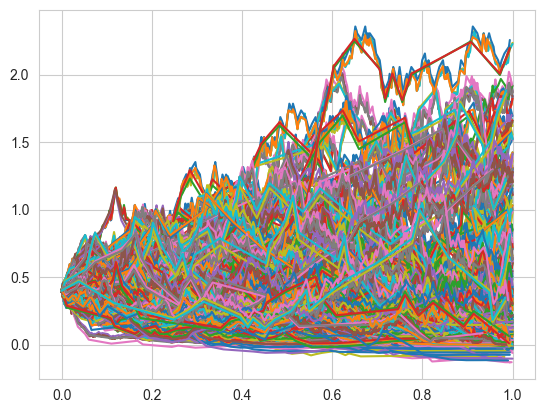

In [172]:
from tqdm import tqdm

for i in tqdm(range(number_of_paths), desc="Processing Paths"):
    # Simulate SABR price path
    t, X, alpha_sabr_t = simulate_sabr(T, n_steps, F0, alpha_sabr0, beta, rho, nu)
    #print(get_optimal_tau(X, alpha, eta))
    # Simulate observed price process
    _, P_fixed, tau_fixed = simulate_observed_price(X, alpha, eta)
    tau_optimal = get_optimal_tau(X, alpha, eta)
    P_optimal = generate_observed_prices(X, tau_optimal, alpha)
    #print(tau_optimal)
    # Compute hedging errors for different strategies
    error_1[i] = calculate_hedging_error(t, X, alpha_sabr_t, X, np.arange(len(t)),K, SABR_PARAMS, True)
    error_2[i] = calculate_hedging_error(t, X, alpha_sabr_t, P_fixed, tau_fixed, K, SABR_PARAMS, False)
    error_3[i] = calculate_hedging_error(t, X, alpha_sabr_t, P_optimal, tau_optimal, K, SABR_PARAMS, False)


In [173]:
print(error_1.mean())
print(error_2.mean())
print(error_3.mean())
print(error_1.std())
print(error_2.std())
print(error_3.std())

0.002498725616590912
-0.11324770534690551
0.016144182564358775
0.01654327397538749
0.049632137705088224
0.04721742681859476


In [174]:
error_2

array([-0.08884857, -0.1821416 , -0.14195856, -0.06786369, -0.04743121,
       -0.14068327, -0.12324849, -0.06533888, -0.083197  , -0.24443943,
       -0.06708625, -0.08132424, -0.06584983, -0.09848702, -0.20775433,
       -0.06404259, -0.10327439, -0.11502814, -0.13435976,  0.01227548,
       -0.1314898 , -0.05000283, -0.10548087, -0.06484805, -0.08303481,
       -0.08925759, -0.10568302, -0.12701984, -0.10057763, -0.10407525,
       -0.09401344, -0.04718981, -0.05821677, -0.09792704, -0.08829089,
       -0.11881922, -0.18182111, -0.03126506, -0.17340316, -0.09990315,
       -0.08430595, -0.16333466, -0.14392924, -0.12079981, -0.08514115,
       -0.18807189, -0.07231998, -0.20316283, -0.12811364, -0.07449836,
       -0.13066185, -0.20940163, -0.15681868, -0.04692688, -0.112744  ,
       -0.20141113, -0.14156021, -0.08984921, -0.17395232, -0.10232709,
       -0.1838172 , -0.08179784, -0.11570344, -0.15641845, -0.09865116,
       -0.0955563 , -0.07704299, -0.16243655, -0.07321977, -0.07

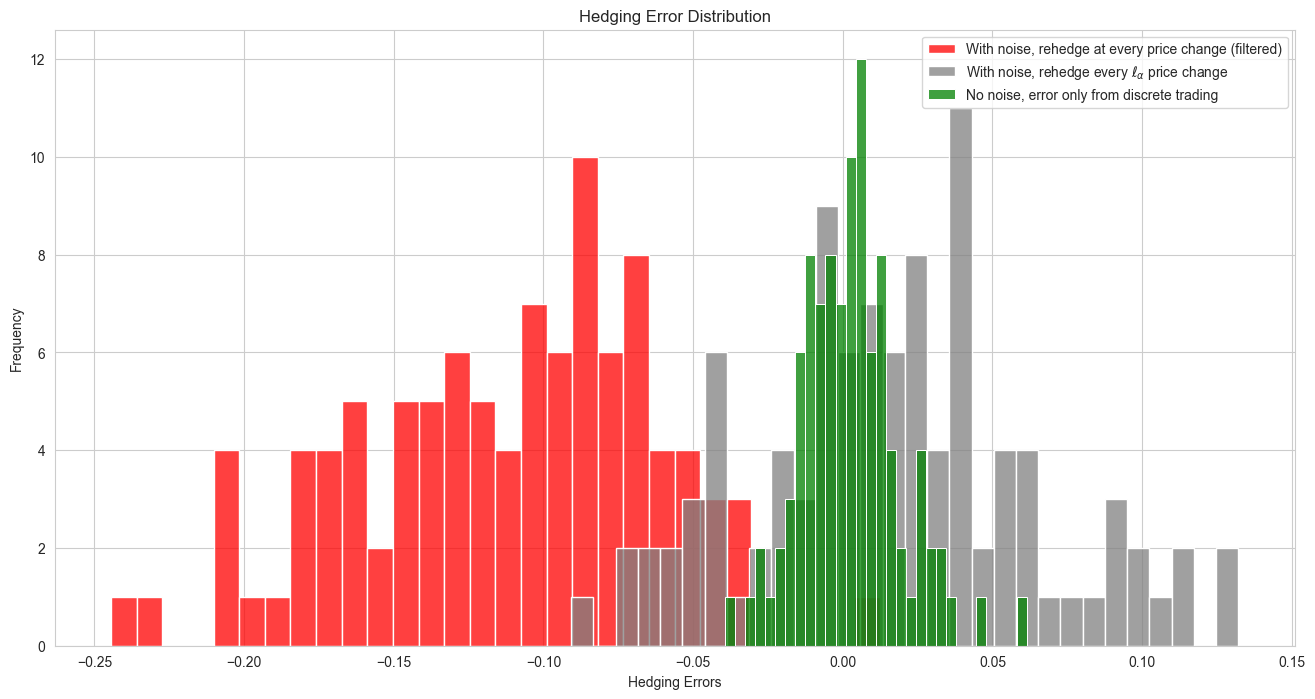

In [175]:

sns.set_style("whitegrid")

# Plot histogram
plt.figure(figsize=(16, 8))
sns.histplot(error_2, label="With noise, rehedge at every price change (filtered)", bins=30, color='red', stat='count', legend=True)
sns.histplot(error_3, label=r"With noise, rehedge every $\ell_\alpha$ price change", bins=30, color='grey', stat='count', legend=True)
sns.histplot(error_1, label="No noise, error only from discrete trading", bins=30, color='green', stat='count', legend=True)

# Labels and Title
plt.xlabel("Hedging Errors")
plt.ylabel("Frequency")
plt.title("Hedging Error Distribution")
plt.legend()
plt.savefig("hedgingError_filtered.pdf", format="pdf")

# Show plot
plt.show()
